### Dependencies

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from scipy.spatial import Delaunay

# Project 3 - Face Morphing

## Part 1. Defining Correspondences

In [2]:
face_a = cv2.imread('../data/filip.jpg')
face_b = cv2.imread('../data/emelie.jpg')

# the points are defined in a json file called filip_emelie.json
with open('../data/filip_emelie.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

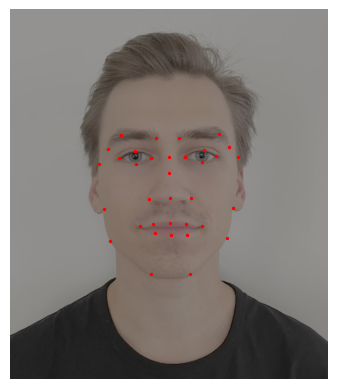

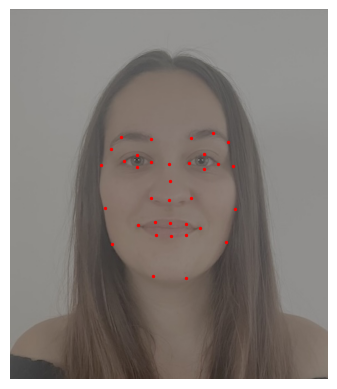

In [3]:
def plot_points_on_face(image, points):
    # Convert image to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot image
    plt.imshow(image_rgb)
    plt.scatter(points[:, 0], points[:, 1], color='red', marker='o', s=2)
    
    # Set title and show the plot
    plt.axis('off')
    plt.show()

plot_points_on_face(face_a, im1_points)
plot_points_on_face(face_b, im2_points)

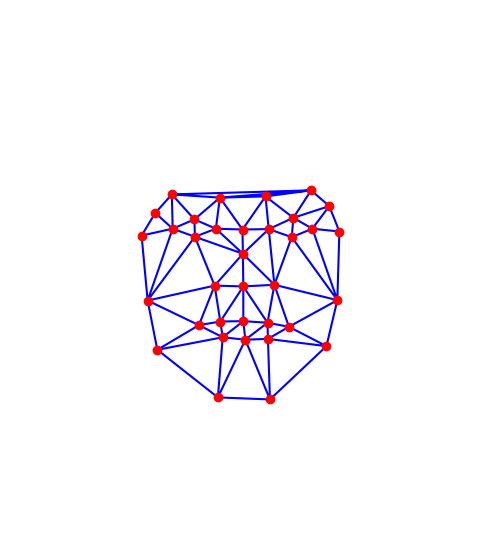

In [4]:
# Compute the midway shape points (average of corresponding points)
midway_points = (im1_points + im2_points) / 2

# Perform Delaunay triangulation on the midway points
tri = Delaunay(midway_points)

# Visualize the triangulation on the midway shape
plt.figure(figsize=(6, 8))  # Adjust the figure size to match the image proportions

# Plot the Delaunay triangulation
plt.triplot(midway_points[:, 0], midway_points[:, 1], tri.simplices, color='blue')
plt.scatter(midway_points[:, 0], midway_points[:, 1], color='red')

# Set the aspect ratio to match the image dimensions
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match image size (width x height = 576 x 670)
plt.xlim(0, 576)
plt.ylim(670, 0)  # Invert Y-axis to match image coordinates

# Display the plot
# plt.title("Delaunay Triangulation of Midway Shape")
plt.axis('off')
plt.show()

## Part 2. Computing the "Mid-way Face"
redo; remove line on nose and merge whole face

In [5]:
def compute_affine(tri1_pts, tri2_pts):
    # Create matrices for triangle points
    tri1 = np.vstack((tri1_pts.T, np.ones((1, 3))))
    tri2 = np.vstack((tri2_pts.T, np.ones((1, 3))))
    
    # Compute the affine transformation matrix A
    A = np.dot(tri2, np.linalg.inv(tri1))
    
    return A

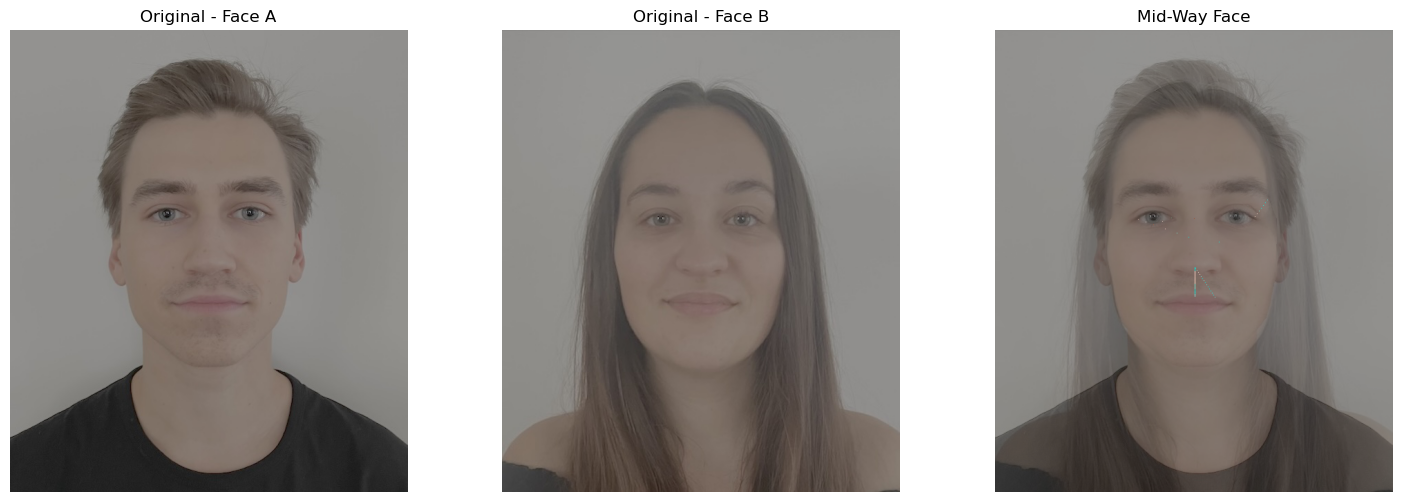

In [6]:
# Helper function to warp a triangle from one image to another
def warp_triangle(img, src_tri, dst_tri, dst_shape):
    # Compute affine transformation matrix
    A = compute_affine(src_tri, dst_tri)
    
    # Create mask for destination triangle
    rr, cc = polygon(dst_tri[:, 1], dst_tri[:, 0], shape=dst_shape)
    
    # Apply inverse warp to find the corresponding pixel in the source image
    coords = np.vstack((cc, rr, np.ones(len(rr))))
    warped_coords = np.dot(np.linalg.inv(A), coords)
    
    # Interpolation to find pixel values in the source image
    x_warped = np.clip(warped_coords[0].astype(int), 0, img.shape[1]-1)
    y_warped = np.clip(warped_coords[1].astype(int), 0, img.shape[0]-1)
    
    # Warp pixels from the source image
    warped_img = np.zeros_like(img)
    warped_img[rr, cc] = img[y_warped, x_warped]
    
    return warped_img

def compute_midway_face(img_a, img_b, points_a, points_b, triangles):
    # Compute the average points (average shape)
    avg_points = (points_a + points_b) / 2
    
    # Initialize the result images with zeros (for storing warped images)
    warped_a = np.zeros_like(img_a)
    warped_b = np.zeros_like(img_b)
    
    # Create masks for each face to blend regions outside the triangles later
    mask_a = np.zeros((img_a.shape[0], img_a.shape[1]), dtype=np.uint8)
    mask_b = np.zeros((img_b.shape[0], img_b.shape[1]), dtype=np.uint8)
    
    # Loop over each triangle and warp both images to the average shape
    for tri_indices in triangles.simplices:
        # Get the points of the triangles in both images and the average
        tri_a = points_a[tri_indices]
        tri_b = points_b[tri_indices]
        tri_avg = avg_points[tri_indices]
        
        # Warp the triangles in both images to the average shape
        warped_a += warp_triangle(img_a, tri_a, tri_avg, img_a.shape)
        warped_b += warp_triangle(img_b, tri_b, tri_avg, img_b.shape)
        
        # Fill the masks with 1s where the triangles are placed
        rr, cc = polygon(tri_avg[:, 1], tri_avg[:, 0], shape=img_a.shape)
        mask_a[rr, cc] = 1
        mask_b[rr, cc] = 1
    
    # Average the colors of the warped images inside the face region
    midway_face = (warped_a / 2 + warped_b / 2).astype(np.uint8)
    
    # Handle the background by averaging the regions outside the triangles
    mask_combined = np.maximum(mask_a, mask_b)
    background_a = img_a * (1 - mask_combined[..., np.newaxis])
    background_b = img_b * (1 - mask_combined[..., np.newaxis])
    
    # Average the background areas and add them to the warped image
    background_avg = (background_a / 2 + background_b / 2).astype(np.uint8)
    final_image = midway_face + background_avg
    
    return final_image

# Load the keypoints (assumed to be loaded from a json or manually clicked)
points_a = np.array(points['im1Points'])
points_b = np.array(points['im2Points'])

# Compute the Delaunay triangulation (using the average shape)
average_points = (points_a + points_b) / 2
tri = Delaunay(average_points)

# Compute the mid-way face
midway_face = compute_midway_face(face_a, face_b, points_a, points_b, tri)

# Display the original and mid-way face
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(face_a, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original - Face A")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(face_b, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original - Face B")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(midway_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Mid-Way Face")

plt.show()

## Part 3. The Morph Sequence

Test

In [7]:
import cv2
import numpy as np

def warp_triangle(src, src_tri, dst_tri, dst_shape):
    """
    Warps a triangle from the source image (src) to the destination image
    defined by the corresponding destination triangle (dst_tri).
    
    Parameters:
    - src: Source image.
    - src_tri: Vertices of the triangle in the source image.
    - dst_tri: Vertices of the triangle in the destination image.
    - dst_shape: Shape of the destination image (height, width, channels).
    
    Returns:
    - Warped part of the image (corresponding to the triangle).
    """
    # Bounding rectangles for the source and destination triangles
    src_rect = cv2.boundingRect(np.float32([src_tri]))
    dst_rect = cv2.boundingRect(np.float32([dst_tri]))
    
    # Offset triangle points by the top-left corner of the bounding box
    src_tri_offset = []
    dst_tri_offset = []
    
    for i in range(3):
        src_tri_offset.append(((src_tri[i][0] - src_rect[0]), (src_tri[i][1] - src_rect[1])))
        dst_tri_offset.append(((dst_tri[i][0] - dst_rect[0]), (dst_tri[i][1] - dst_rect[1])))
    
    # Cropping the source image
    src_img_cropped = src[src_rect[1]:src_rect[1]+src_rect[3], src_rect[0]:src_rect[0]+src_rect[2]]
    
    # Warp the cropped source image to the destination triangle
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_offset), np.float32(dst_tri_offset))
    warped_triangle = cv2.warpAffine(src_img_cropped, warp_mat, (dst_rect[2], dst_rect[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Create a mask for the destination triangle
    mask = np.zeros((dst_rect[3], dst_rect[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), 1, 16, 0)
    
    # Prepare the destination part (same size as the destination image)
    dest_img_part = np.zeros((dst_shape[0], dst_shape[1], dst_shape[2]), dtype=src.dtype)
    
    # Use only the triangular area of the warped image
    dest_img_part[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]] = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask)
    
    return dest_img_part


def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    """
    Morphs two images based on given triangulation and fractions for warping and dissolving.
    
    Parameters:
    - im1: The first image.
    - im2: The second image.
    - im1_pts: Corresponding points on the first image.
    - im2_pts: Corresponding points on the second image.
    - tri: Delaunay triangulation structure (based on averaged points).
    - warp_frac: Controls shape warping (range [0,1]).
    - dissolve_frac: Controls cross-dissolve (range [0,1]).
    
    Returns:
    - morphed_im: The morphed output image.
    """
    # Step 1: Compute intermediate shape points based on warp_frac
    intermediate_pts = (1 - warp_frac) * im1_pts + warp_frac * im2_pts
    
    # Step 2: Initialize warped images for im1 and im2
    warped_im1 = np.zeros_like(im1)
    warped_im2 = np.zeros_like(im2)
    
    # Step 3: Warp triangles of both images into the intermediate shape
    for tri_indices in tri.simplices:
        # Get triangle vertices from both images and intermediate shape
        tri_im1 = im1_pts[tri_indices]
        tri_im2 = im2_pts[tri_indices]
        tri_intermediate = intermediate_pts[tri_indices]
        
        # Warp im1 and im2 to the intermediate shape
        warped_im1 += warp_triangle(im1, tri_im1, tri_intermediate, im1.shape)
        warped_im2 += warp_triangle(im2, tri_im2, tri_intermediate, im2.shape)
    
    # Step 4: Cross dissolve the warped images using dissolve_frac
    morphed_im = (1 - dissolve_frac) * warped_im1 + dissolve_frac * warped_im2

    # Step 5: Blend the full images (not just the warped regions)
    morphed_im_full = (1 - dissolve_frac) * im1 + dissolve_frac * im2

    # Create a mask for the warped regions
    mask = np.any(warped_im1 > 0, axis=-1)  # Create mask where any channel is > 0

    # Only apply the morphed regions to the corresponding areas in the full image
    morphed_im_full[mask] = morphed_im[mask]

    return morphed_im_full.astype(np.uint8)

def create_morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames, output_path):
    """
    Creates a video sequence that morphs image im1 into image im2 using point correspondences and triangulation.
    
    Parameters:
    - im1: The first image (as a numpy array).
    - im2: The second image (as a numpy array).
    - im1_pts: Corresponding points on the first image (n x 2 array).
    - im2_pts: Corresponding points on the second image (n x 2 array).
    - tri: Delaunay triangulation structure for the points.
    - num_frames: Number of frames in the output video.
    - output_path: Path to save the output video.
    
    Returns:
    - None. A video file is saved at the specified output path.
    """
    # Ensure that both images have the same shape
    assert im1.shape == im2.shape, "Images must have the same shape."
    
    # Video writer setup
    height, width, channels = im1.shape
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    # Iterate through the number of frames
    for i in range(num_frames):
        # Calculate warp_frac and dissolve_frac for this frame
        warp_frac = i / (num_frames - 1)
        dissolve_frac = i / (num_frames - 1)
        
        # Compute the morphed image
        morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac)
        
        # Convert RGB to BGR for saving with OpenCV (OpenCV uses BGR by default)
        frame_bgr = cv2.cvtColor(morphed_im, cv2.COLOR_RGB2BGR)
        
        # Write the frame to the video
        video.write(frame_bgr)
    
    # Release the video writer
    video.release()

    print(f"Morphing video saved at {output_path}")

# Example call to create the morph sequence
create_morph_sequence(face_a, face_b, im1_points, im2_points, tri, num_frames=30, output_path="morph_sequence.mp4")

Morphing video saved at morph_sequence.mp4


end test

In [31]:
import numpy as np
import cv2
from scipy.spatial import Delaunay
import skimage.draw

def compute_affine(tri1_pts, tri2_pts):
    """Computes the affine transformation matrix A that maps tri1_pts to tri2_pts."""
    ones = np.ones((3, 1))
    tri1_pts_aug = np.hstack([tri1_pts, ones])  # Convert to homogeneous coordinates
    tri2_pts_aug = np.hstack([tri2_pts, ones])  # Convert to homogeneous coordinates
    A = np.linalg.lstsq(tri1_pts_aug, tri2_pts_aug, rcond=None)[0].T
    return A

def warp_triangle(src, src_tri, dst_tri, dst_shape):
    """Warp a triangular region from the source image to the destination."""
    # Bounding box for destination triangle
    r = cv2.boundingRect(np.float32([dst_tri]))
    
    # Offsets and affine transform
    dst_tri_offset = np.array([[p[0] - r[0], p[1] - r[1]] for p in dst_tri])
    src_tri_offset = np.array([[p[0], p[1]] for p in src_tri])
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_offset), np.float32(dst_tri_offset))
    
    # Warp source image triangle to the size of the destination bounding box
    warped_triangle = cv2.warpAffine(src, warp_mat, (r[2], r[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Create a mask for the triangle and place the warped triangle on the destination image
    mask = np.zeros((r[3], r[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), 1, 16, 0)
    dest_img_part = np.zeros_like(dst_shape)
    dest_img_part[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask)
    
    return dest_img_part

def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    # Compute the average shape points
    intermediate_pts = (1 - warp_frac) * np.array(im1_pts) + warp_frac * np.array(im2_pts)
    
    # Create the destination image with float64 precision for computation
    morphed_im = np.zeros_like(im1, dtype=np.float64)
    
    # Create a mask to define the region where the face is morphed
    mask = np.zeros(im1.shape[:2], dtype=np.uint8)
    
    for t in tri.simplices:
        tri1_pts = np.array([im1_pts[t[0]], im1_pts[t[1]], im1_pts[t[2]]])
        tri2_pts = np.array([im2_pts[t[0]], im2_pts[t[1]], im2_pts[t[2]]])
        intermediate_tri_pts = np.array([intermediate_pts[t[0]], intermediate_pts[t[1]], intermediate_pts[t[2]]])
        
        # Warp the triangles from im1 and im2 to the intermediate shape
        warped_im1 = warp_triangle(im1, tri1_pts, intermediate_tri_pts, morphed_im)
        warped_im2 = warp_triangle(im2, tri2_pts, intermediate_tri_pts, morphed_im)
        
        # Blend the two warped images using dissolve_frac
        blended_triangle = (1 - dissolve_frac) * warped_im1.astype(np.float64) + dissolve_frac * warped_im2.astype(np.float64)
        
        # Create a mask of the triangle area and add to the final image
        cv2.fillConvexPoly(mask, np.int32(intermediate_tri_pts), 255)
        morphed_im += blended_triangle

    # Clip values to [0, 255] and convert back to uint8
    morphed_im = np.clip(morphed_im, 0, 255).astype(np.uint8)

    # Handle the background part: dissolve the non-face areas
    background = (1 - dissolve_frac) * im1.astype(np.float64) + dissolve_frac * im2.astype(np.float64)
    
    # Create an inverted mask to cover non-face areas
    mask_inv = cv2.bitwise_not(mask)
    
    # Combine the morphed face with the dissolved background
    face_part = cv2.bitwise_and(morphed_im, morphed_im, mask=mask)
    background_part = cv2.bitwise_and(background.astype(np.uint8), background.astype(np.uint8), mask=mask_inv)
    
    # Combine both parts together to get the final morphed image
    result = cv2.add(face_part, background_part)

    return result

# Compute the Delaunay triangulation based on average points
mean_pts = (np.array(im1_points) + np.array(im2_points)) / 2
tri = Delaunay(mean_pts)

# Test with some warp and dissolve fractions (e.g., halfway)
morphed_im = morph(face_a, face_b, im1_points, im2_points, tri, warp_frac=0.5, dissolve_frac=0.5)

# Show the result
# cv2.imshow("Morphed Image", morphed_im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [11]:
import imageio
import cv2

def create_morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames=30):
    frames = []
    for frac in np.linspace(0, 1, num_frames):
        morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac=frac, dissolve_frac=frac)
        # Convert BGR to RGB
        morphed_im_rgb = cv2.cvtColor(morphed_im, cv2.COLOR_BGR2RGB)
        frames.append(morphed_im_rgb)
    
    return frames

# Generate morph frames
frames = create_morph_sequence(face_a, face_b, im1_points, im2_points, tri, num_frames=30)

# Save as GIF
imageio.mimsave('morph_sequence.gif', frames, fps=10)

## Part 4. The "Mean face" of a population

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [25]:
import os
import glob
import cv2
import numpy as np

def load_images_and_landmarks(path):
    images = []
    landmarks = []
    
    # Find all male, neutral images (e.g., "01-1m.jpg")
    image_files = glob.glob(os.path.join(path, '*-1m.jpg'))
    
    for img_file in image_files:
        # Load the image
        img = cv2.imread(img_file)
        if img is None:
            print(f"Warning: {img_file} could not be read. Skipping this file.")
            continue
        images.append(img)
        
        # Load the corresponding .asf file
        asf_file = img_file.replace('.jpg', '.asf')
        points = []

        with open(asf_file, 'r') as f:
            lines = f.readlines()
            
            # Look for the number of model points (usually found after headers)
            num_points_found = False
            for line in lines:
                if line.strip().startswith('#'):
                    continue  # Ignore lines starting with #
                
                if line.strip() == "58":  # Look for the number of points
                    num_points_found = True
                    continue
                
                # Start extracting points after the number of model points is found
                if num_points_found:
                    parts = line.split()
                    if len(parts) >= 7:
                        x, y = float(parts[2]), float(parts[3])
                        points.append((x, y))

        
        # Ensure there are exactly 58 landmarks
        if len(points) == 58:
            landmarks.append(np.array(points))
        else:
            print(f"Warning: {asf_file} has {len(points)} landmarks instead of 58. Skipping this file.")
        
    return images, landmarks

# Example usage
path = '../data/imm_face_db/'
images, landmarks = load_images_and_landmarks(path)
print(f'Loaded {len(images)} images and their corresponding landmarks.')

Loaded 33 images and their corresponding landmarks.


In [26]:
def normalize_landmarks(landmarks, img_shape):
    height, width = img_shape[:2]
    normalized = [(x * width, y * height) for x, y in landmarks]
    return np.array(normalized)

# Normalize landmarks for each image
normalized_landmarks = [normalize_landmarks(landmark, img.shape) for landmark, img in zip(landmarks, images)]

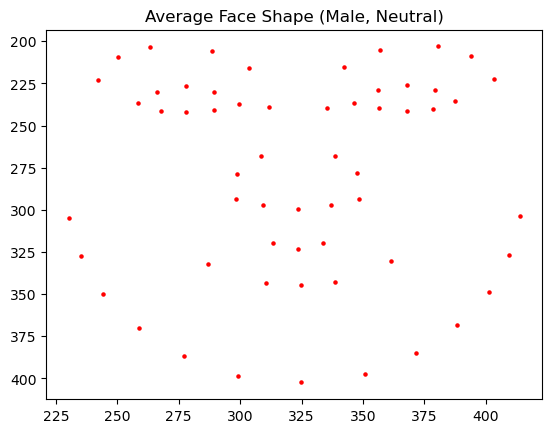

In [27]:
def compute_average_shape(landmarks):
    # Stack all landmark points into an array
    stacked_landmarks = np.array(landmarks)
    # Compute the mean along the first axis to get the average shape
    avg_shape = np.mean(stacked_landmarks, axis=0)
    return avg_shape

average_landmark = compute_average_shape(normalized_landmarks)

# Plot the average landmark points to visualize
plt.scatter(average_landmark[:, 0], average_landmark[:, 1], color='red', s=5)
plt.title('Average Face Shape (Male, Neutral)')
plt.gca().invert_yaxis()  # Invert Y axis for proper image alignment
plt.show()

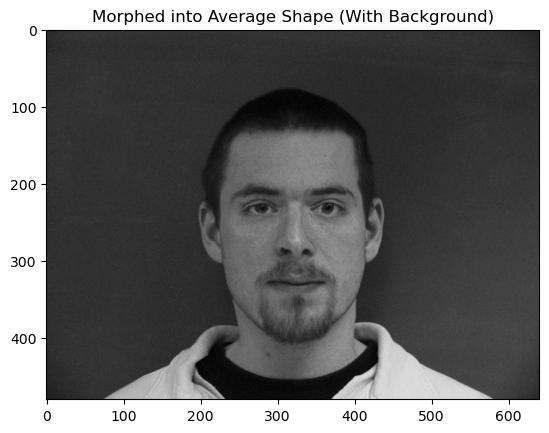

In [37]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def add_boundary_points(landmarks, img_shape):
    """Add image corners to the landmarks to include the background."""
    height, width = img_shape[:2]
    boundary_points = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)]
    return np.vstack([landmarks, boundary_points])

# Add boundary points to both the normalized landmarks and the average landmarks
extended_landmarks = [add_boundary_points(landmark, img.shape) for landmark, img in zip(normalized_landmarks, images)]
extended_average_landmark = add_boundary_points(average_landmark, images[0].shape)

def delaunay_triangulation(points):
    return Delaunay(points)

def affine_transform(src, dst, img, size):
    # Calculate the affine transformation matrix
    warp_matrix = cv2.getAffineTransform(np.float32(src), np.float32(dst))
    # Warp the image using the affine transformation matrix
    warped = cv2.warpAffine(img, warp_matrix, (size[1], size[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return warped

def morph_to_average_shape_with_background(img, landmarks, average_shape, img_shape):
    # Add boundary points to landmarks and average shape
    extended_landmarks = add_boundary_points(landmarks, img_shape)
    extended_avg_shape = add_boundary_points(average_shape, img_shape)
    
    # Compute Delaunay triangulation for the average shape with boundary points
    tri = delaunay_triangulation(extended_avg_shape)
    
    # Create an empty canvas for the warped image
    morphed_img = np.zeros(img_shape, dtype=img.dtype)
    
    # Warp each triangle from the original face to the average face
    for simplex in tri.simplices:
        # Get the points for each triangle in the original face
        src_triangle = extended_landmarks[simplex]
        # Get the points for each triangle in the average shape
        dst_triangle = extended_avg_shape[simplex]
        
        # Perform affine transformation
        warped_triangle = affine_transform(src_triangle, dst_triangle, img, img_shape)
        
        # Create a mask for the triangle and add it to the morphed image
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_triangle), 255)
        morphed_img[mask > 0] = warped_triangle[mask > 0]
    
    return morphed_img

# Morph each face with the background into the average shape
morphed_images_with_background = [morph_to_average_shape_with_background(img, landmark, average_landmark, img.shape) for img, landmark in zip(images, normalized_landmarks)]

# Display an example morphed image with the background
plt.imshow(cv2.cvtColor(morphed_images_with_background[0], cv2.COLOR_BGR2RGB))
plt.title("Morphed into Average Shape (With Background)")
plt.show()

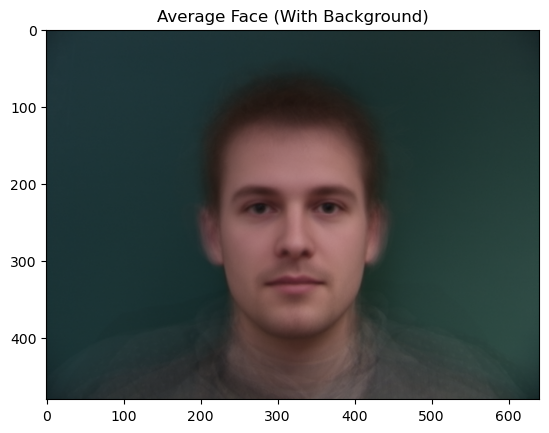

In [38]:
def compute_average_face(morphed_images):
    # Stack the morphed images and compute the mean along the first axis
    avg_face = np.mean(np.array(morphed_images), axis=0).astype(np.uint8)
    return avg_face

# Compute the average face with background
average_face_with_background = compute_average_face(morphed_images_with_background)

# Display the average face with background
plt.imshow(cv2.cvtColor(average_face_with_background, cv2.COLOR_BGR2RGB))
plt.title("Average Face (With Background)")
plt.show()

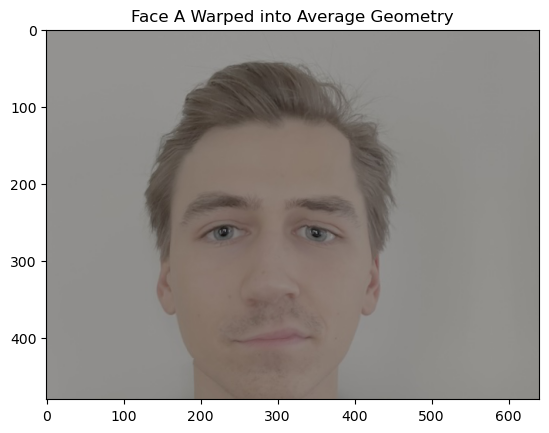

In [40]:
# Warp the first face to the average geometry
face_to_avg = morph_to_average_shape_with_background(face_a, normalized_landmarks[0], average_landmark, images[0].shape)

# Display the result
plt.imshow(cv2.cvtColor(face_to_avg, cv2.COLOR_BGR2RGB))
plt.title("Face A Warped into Average Geometry")
plt.show()

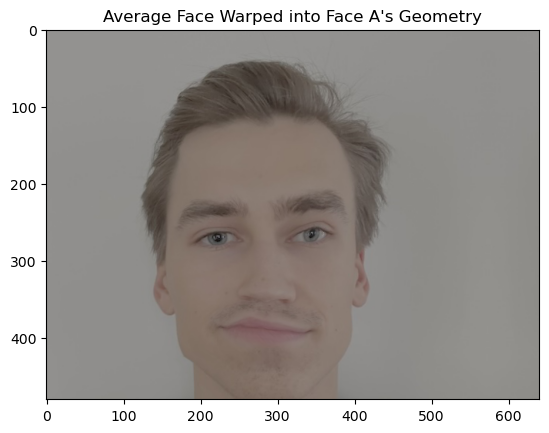

In [41]:
# Warp the average face to the geometry of face A
avg_to_face_a = morph_to_average_shape_with_background(face_a, average_landmark, normalized_landmarks[0], images[0].shape)

# Display the result
plt.imshow(cv2.cvtColor(avg_to_face_a, cv2.COLOR_BGR2RGB))
plt.title("Average Face Warped into Face A's Geometry")
plt.show()

New code

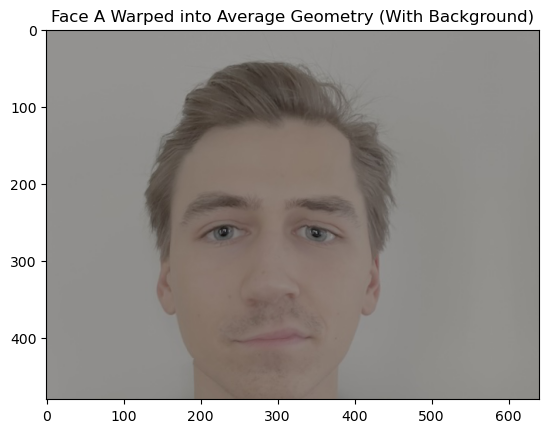

In [43]:
# Warp face_a (first image) into the average face geometry
def warp_face_to_average(img, img_landmarks, average_landmarks, img_shape):
    return morph_to_average_shape_with_background(img, img_landmarks, average_landmarks, img_shape)

# Use the first face's landmarks and warp it into the average face's geometry
face_a_to_average_geometry = warp_face_to_average(face_a, normalized_landmarks[0], average_landmark, images[0].shape)

# Display the result
plt.imshow(cv2.cvtColor(face_a_to_average_geometry, cv2.COLOR_BGR2RGB))
plt.title("Face A Warped into Average Geometry (With Background)")
plt.show()

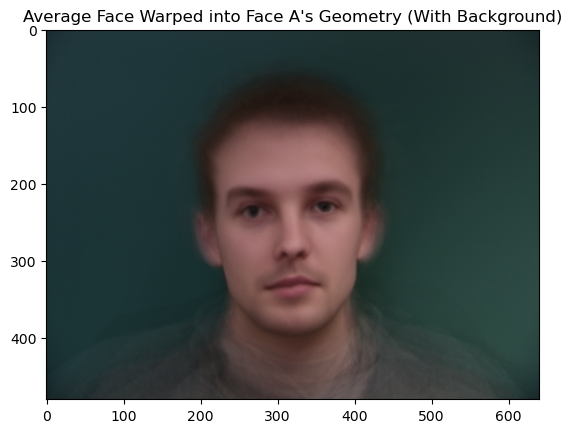

In [44]:
# Warp the average face into the geometry of face_a (first image)
def warp_average_to_face(img, img_landmarks, average_landmarks, img_shape):
    return morph_to_average_shape_with_background(img, average_landmarks, img_landmarks, img_shape)

# Warp the average face into face_a's geometry
average_face_to_face_a_geometry = warp_average_to_face(average_face_with_background, normalized_landmarks[0], average_landmark, images[0].shape)

# Display the result
plt.imshow(cv2.cvtColor(average_face_to_face_a_geometry, cv2.COLOR_BGR2RGB))
plt.title("Average Face Warped into Face A's Geometry (With Background)")
plt.show()

## Part 5. Caricatures: Extrapolating from the mean